In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy import signal
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPool1D
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop


In [3]:
tf.__version__

'2.11.0'

In [4]:
RAND_SEED = 42
tf.random.set_seed(RAND_SEED)
np.random.seed(RAND_SEED)


In [5]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


We can use "Sensors Activity Dataset" by Shoaib et al. which is available for download from (https://www.utwente.nl/en/eemcs/ps/research/dataset/).
There are 7 activities in this dataset: Biking, Downstairs, Jogging, Sitting, Standing, Upstairs, Walking. 
There were ten participants involved in data collection experiment who performed  each of these activities for 3-4 minutes.
All ten participants were male, between the ages of 25 and 30. 
Each of these participants was equipped with five smartphones on five body positions: 

1. One in their right jean’s pocket. 
2. One in their left jean’s pocket.
3. One on belt position towards the right leg using a belt clipper.
4. One on the right upper arm. 
5. One on the right wrist.

The data was collected for an accelerometer, a gyroscope, a magnetometer, and a linear acceleration sensor. 
Each csv file contains data for each participant's seven physical activities for all five positions. 

Notation in these files: 

Accelerometer ( Ax = x-axis, Ay = y-axis, Az= Z-axis)   
Linear Acceleration Sensor ( Lx = x-axis, Ly = y axis, Lz= Z-axis)   
Gyroscope ( Gx = x-axis, Gy = y-axis, Gz= Z-axis)   
Magnetometer ( Mx = x-axis, My = y-axis, Mz= Z-axis) 



# Download dataset
* download Datastet from (https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar)


In [6]:
p = np.arange(10)
np.random.shuffle(p)  # shuffle participants order
print(p)

[8 1 5 0 7 2 9 4 3 6]


In [7]:
df = pd.DataFrame()
for i in p:
    df_tmp = pd.read_csv('./DataSet/Participant_' +
                         str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])
    del(df_tmp)
# View top 5 rows of dataframe
df.head()


,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,...,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-3.6775,-13.8930,-4.33130,0.023408,-4.81160,-4.25360,-2.2550,1.30020,0.84544,...,-3.9316,1.687600,3.25020,0.73854,-2.0953,0.25137,-13.02,11.70,8.34,walking
1,1.390000e+12,-3.3778,-12.4900,-4.11330,0.206080,-3.36980,-3.72460,-1.9071,1.39740,0.64446,...,-4.6994,0.503650,2.11310,1.19700,-2.3769,0.40623,-12.72,11.64,8.94,walking
2,1.390000e+12,-1.3212,-11.0730,-0.14982,1.930500,-1.83540,0.35694,-1.8524,0.94959,0.48778,...,-5.2183,-0.278040,0.41354,1.04310,-2.2281,0.18479,-12.06,11.70,10.32,walking
3,1.390000e+12,-1.4029,-9.0031,2.02940,1.548400,0.34697,2.22210,-2.1738,0.60018,0.41783,...,-5.2325,0.094103,0.97650,0.66065,-1.3314,-0.26848,-11.58,11.82,10.92,walking
4,1.390000e+12,-2.6560,-7.7772,3.24160,0.293820,1.56930,2.90670,-1.2333,1.94800,1.05130,...,-4.8999,0.859700,1.61160,0.51282,-1.0162,-0.39615,-11.10,11.82,11.76,walking


## Train-Test random split by users
Train 80 % (where 25 % will be used for validation)

Test 20%


In [9]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
# del(df)


Number of train samples:  504000
Number of test samples:  126000


In [10]:
def concat(data: pd.DataFrame):
    '''
    This functions splits test and train data by position 
    with relevant features, in our case: Acc(x, y, z)
    '''
    # Select left pocket data
    left_pocket = data.iloc[:, 1:13]

    # Computes Euclidean Norm for every sensor data
    left_pocket["MA"] = np.sqrt(np.square(
        left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["MG"] = np.sqrt(np.square(
        left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    left_pocket["MM"] = np.sqrt(np.square(
        left_pocket['Mx']) + np.square(left_pocket['My']) + np.square(left_pocket['Mz']))
    left_pocket["ML"] = np.sqrt(np.square(
        left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))

    # drops unused columns
    left_pocket = left_pocket.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz',
                                    'Mx', 'My', 'Mz', 'MG', 'MM', 'MA', 'ML'], axis=1)

    # Select right pocket data
    right_pocket = data.iloc[:, 15:27]
    right_pocket.columns = ['Ax', 'Ay', 'Az', 'Lx',
                            'Ly', 'Lz', 'Gx', 'Gy', 'Gz',  'Mx', 'My', 'Mz']  # type: ignore

    # Square root of sum of squares of accelerometer, gyroscope data and Magnetic Field data
    right_pocket["MA"] = np.sqrt(np.square(
        right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["MG"] = np.sqrt(np.square(
        right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))
    right_pocket["MM"] = np.sqrt(np.square(
        right_pocket['Mx']) + np.square(right_pocket['My']) + np.square(right_pocket['Mz']))
    right_pocket["ML"] = np.sqrt(np.square(
        right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))

    # drops unused columns
    right_pocket = right_pocket.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz',
                                      'Mx', 'My', 'Mz', 'MG', 'MM', 'MA', 'ML'], axis=1)

    # Select right wrist data
    right_wrist = data.iloc[:, 29:41]
    right_wrist.columns = ['Ax', 'Ay', 'Az', 'Lx',
                           'Ly', 'Lz', 'Gx', 'Gy', 'Gz',  'Mx', 'My', 'Mz']  # type: ignore

    # Square root of sum of squares of accelerometer, gyroscope data and Magnetic Field data
    right_wrist["MA"] = np.sqrt(np.square(
        right_wrist['Ax']) + np.square(right_wrist['Ay']) + np.square(right_wrist['Az']))
    right_wrist["MG"] = np.sqrt(np.square(
        right_wrist['Gx']) + np.square(right_wrist['Gy']) + np.square(right_wrist['Gz']))
    right_wrist["MM"] = np.sqrt(np.square(
        right_wrist['Mx']) + np.square(right_wrist['My']) + np.square(right_wrist['Mz']))
    right_wrist["ML"] = np.sqrt(np.square(
        right_wrist['Lx']) + np.square(right_wrist['Ly']) + np.square(right_wrist['Lz']))

    # drops unused columns
    right_wrist = right_wrist.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz',
                                    'Mx', 'My', 'Mz', 'MG', 'MM', 'MA', 'ML'], axis=1)

    # Select right upper arm data
    right_upper_arm = data.iloc[:, 43:55]
    right_upper_arm.columns = ['Ax', 'Ay', 'Az', 'Lx',
                               'Ly', 'Lz', 'Gx', 'Gy', 'Gz',  'Mx', 'My', 'Mz']  # type: ignore

    # Square root of sum of squares of accelerometer, gyroscope data and Magnetic Field data
    right_upper_arm["MA"] = np.sqrt(np.square(
        right_upper_arm['Ax']) + np.square(right_upper_arm['Ay']) + np.square(right_upper_arm['Az']))
    right_upper_arm["MG"] = np.sqrt(np.square(
        right_upper_arm['Gx']) + np.square(right_upper_arm['Gy']) + np.square(right_upper_arm['Gz']))
    right_upper_arm["MM"] = np.sqrt(np.square(
        right_upper_arm['Mx']) + np.square(right_upper_arm['My']) + np.square(right_upper_arm['Mz']))
    right_upper_arm["ML"] = np.sqrt(np.square(
        right_upper_arm['Lx']) + np.square(right_upper_arm['Ly']) + np.square(right_upper_arm['Lz']))

    # drops unused columns
    right_upper_arm = right_upper_arm.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy',
                                            'Gz',  'Mx', 'My', 'Mz', 'MG', 'MM', 'MA', 'ML'], axis=1)

    # Select beltdata
    belt = data.iloc[:, 57:69]
    belt.columns = ['Ax', 'Ay', 'Az', 'Lx', 'Ly',
                    'Lz', 'Gx', 'Gy', 'Gz',  'Mx', 'My', 'Mz']  # type: ignore

    # Square root of sum of squares of accelerometer, gyroscope data and Magnetic Field data
    belt["MA"] = np.sqrt(np.square(belt['Ax']) +
                         np.square(belt['Ay']) + np.square(belt['Az']))
    belt["MG"] = np.sqrt(np.square(belt['Gx']) +
                         np.square(belt['Gy']) + np.square(belt['Gz']))
    belt["MM"] = np.sqrt(np.square(belt['Mx']) +
                         np.square(belt['My']) + np.square(belt['Mz']))
    belt["ML"] = np.sqrt(np.square(
        belt['Lx']) + np.square(belt['Ly']) + np.square(belt['Lz']))

    # drops unused columns
    belt = belt.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz',
                      'Mx', 'My', 'Mz', 'MG', 'MM', 'MA', 'ML'], axis=1)
    # choose data to use according to position

    # df = df.drop(['Lx', 'Ly', 'Lz', 'Gx', 'Gy',
    #             'Gz',  'Mx', 'My', 'Mz', 'MG', 'MM'], axis=1)

    # Extract labels
    labels = data.iloc[:, 69]
    labels = labels.to_frame()
    labels.columns = ['Activity_Label']  # type: ignore
    labels = pd.concat([labels], ignore_index=True)
    # replace typo 'upsatirs' with upstairs!
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'

    return right_upper_arm, right_wrist, belt, right_pocket, left_pocket, labels


## Generate input data and labels

In [11]:
upper_arm_X, wrist_X,  belt_X, r_pocket_X, l_pocket_X, train_y = concat(
    train_data)

upper_arm_test_X, wrist_test_X, belt_test_X, r_pocket_test_X, l_pocket_test_X, test_y = concat(
    test_data)


In [12]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train_y.Activity_Label = le.fit_transform(train_y.Activity_Label)
# test_y.Activity_Label = le.transform(test_y.Activity_Label)


## Generate data sequence

In [13]:
def generate_sequence(X: pd.DataFrame, y: pd.DataFrame, n_time_steps: int = 100, step: int = 50):
    ''' Generate sequences of given window size

    Parameters
    ----------
    X : pd.DataFrame
        Dataframe containing features
    y : pd.DataFrame
        Dataframe of labels
    n_time_steps : int, optional
        Windows size in number of samples, default is 100 (i.e 2s = 100 @50Hz)
    step : int, optional
        overlap size, default to 50

    Returns
    -------
    segments : array_like
        created `segments` of X
    labels : array_like
        transformed `labels` by pandas dummies

    '''
    segments = []
    labels = []
    for i in range(0, len(X) - n_time_steps, step):
        if(not np.all(y.iloc[i:i+n_time_steps]['Activity_Label'].values == y.iloc[i]['Activity_Label'])):
            continue
        # segments.append(X.iloc[i: i+n_time_steps].abs().values)
        segments.append(X.iloc[i: i+n_time_steps].values)
        # segments.append(signal.resample(
        #     X.iloc[i: i+n_time_steps].abs().values, 40))
        labels.append(y.iloc[i]['Activity_Label'])

    segments = np.asarray(segments, dtype=np.float32)
    labels = np.asarray(pd.get_dummies(labels), dtype=np.float32) # type: ignore
    return segments, labels


In [14]:
X_train_wrist, y_train_wrist = generate_sequence(wrist_X, train_y, 100, 50)
X_test_wrist, y_test_wrist = generate_sequence(
    wrist_test_X, test_y, 100, 50)

X_train_belt, y_train_belt = generate_sequence(belt_X, train_y, 100, 50)
X_test_belt, y_test_belt = generate_sequence(belt_test_X, test_y, 100, 50)

X_train_r_pocket, y_train_r_pocket = generate_sequence(
    r_pocket_X, train_y, 100, 50)
X_test_r_pocket, y_test_r_pocket = generate_sequence(
    r_pocket_test_X, test_y, 100, 50)

X_train_l_pocket, y_train_l_pocket = generate_sequence(
    l_pocket_X, train_y, 100, 50)
X_test_l_pocket, y_test_l_pocket = generate_sequence(
    l_pocket_test_X, test_y, 100, 50)

X_train_upper_arm, y_train_upper_arm = generate_sequence(
    upper_arm_X, train_y, 100, 50)
X_test_upper_arm, y_test_upper_arm = generate_sequence(
    upper_arm_test_X, test_y, 100, 50)


In [15]:
X = pd.concat([upper_arm_X, wrist_X,  belt_X, r_pocket_X, l_pocket_X], axis=1)
X_test = pd.concat(
    [upper_arm_test_X, wrist_test_X, belt_test_X, r_pocket_test_X, l_pocket_test_X], axis=1)



In [16]:
X_train_all, y_train_all = generate_sequence(X, train_y, 100, 50)
X_test_all, y_test_all = generate_sequence(X_test, test_y, 100, 50)
X_train_all.shape

(10023, 100, 15)

# Building Models

In [17]:
N_FEATURES = 3

CLASSES = 7
BATCH_SIZE = 1024
EPOCHS = 100
L2 = 0.000001 # not used for now

Multi-Inputs (Multi-Position) Model

In [18]:
# UPPER_ARM
inputs_ua = tf.keras.Input(shape=(100, N_FEATURES), name='Inputs_upperarm')
x_ua = Conv1D(32, 3, activation='relu')(inputs_ua)
x_ua = Conv1D(32, 3, activation='relu')(x_ua)
x_ua = MaxPool1D(2)(x_ua)
x_ua = Dropout(.6)(x_ua)
x_ua = Flatten()(x_ua)
x_ua = Dense(16, activation='relu')(x_ua)

# WRIST
inputs_w = tf.keras.Input(shape=(100, N_FEATURES), name='Inputs_wrist')
x_w = Conv1D(32, 3, activation='relu')(inputs_w)
x_w = Conv1D(32, 3, activation='relu')(x_w)
x_w = MaxPool1D(2)(x_w)
x_w = Dropout(.6)(x_w)
x_w = Flatten()(x_w)
x_w = Dense(16, activation='relu')(x_w)

# BELT
inputs_b = tf.keras.Input(shape=(100, N_FEATURES), name='Inputs_belt')
x_b = Conv1D(32, 3, activation='relu')(inputs_b)
x_b = Conv1D(32, 3, activation='relu')(x_b)
x_b = MaxPool1D(2)(x_b)
x_b = Dropout(.6)(x_b)
x_b = Flatten()(x_b)
x_b = Dense(16, activation='relu')(x_b)

# RIGHT_POCKET
inputs_rp = tf.keras.Input(shape=(100, N_FEATURES), name='Inputs_right_pocket')
x_rp = Conv1D(32, 3, activation='relu')(inputs_rp)
x_rp = Conv1D(32, 3, activation='relu')(x_rp)
x_rp = MaxPool1D(2)(x_rp)
x_rp = Dropout(.6)(x_rp)
x_rp = Flatten()(x_rp)
x_rp = Dense(16, activation='relu')(x_rp)

# LEFT_POCKET
inputs_lp = tf.keras.Input(shape=(100, N_FEATURES), name='Inputs_left_pocket')
x_lp = Conv1D(32, 3, activation='relu')(inputs_lp)
x_lp = Conv1D(32, 3, activation='relu')(x_lp)
x_lp = MaxPool1D(2)(x_lp)
x_lp = Dropout(.6)(x_lp)
x_lp = Flatten()(x_lp)
x_lp = Dense(16, activation='relu')(x_lp)

x = tf.keras.layers.concatenate([x_ua, x_w, x_b, x_rp, x_lp])
x = Dense(64, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(64, activation='relu')(x)
# x = Dropout(.5)(x)
x = Dense(32, activation='relu')(x)
# x = Dropout(.5)(x)
out_layer = Dense(CLASSES, activation='softmax')(x)

model_ua = tf.keras.Model(inputs=inputs_ua,  outputs=x_ua)
model_w = tf.keras.Model(inputs=inputs_w,  outputs=x_w)
model_b = tf.keras.Model(inputs=inputs_b,  outputs=x_b)
model_rp = tf.keras.Model(inputs=inputs_rp,  outputs=x_rp)
model_lp = tf.keras.Model(inputs=inputs_lp,  outputs=x_lp)

g_model = tf.keras.Model(
    inputs=[x_ua, x_w, x_b, x_rp, x_lp],  outputs=out_layer)

model_multi = tf.keras.Model(
    inputs=[inputs_ua, inputs_w, inputs_b, inputs_rp, inputs_lp], outputs=out_layer, name='Multi_Inputs_Model')

model_multi.summary()


Model: "Multi_Inputs_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs_upperarm (InputLayer)   [(None, 100, 3)]     0           []                               
                                                                                                  
 Inputs_wrist (InputLayer)      [(None, 100, 3)]     0           []                               
                                                                                                  
 Inputs_belt (InputLayer)       [(None, 100, 3)]     0           []                               
                                                                                                  
 Inputs_right_pocket (InputLaye  [(None, 100, 3)]    0           []                               
 r)                                                                              

Single Input (Multi-Position) Model

In [21]:
opt = RMSprop(learning_rate=0.0005)

# TODO : To be later implemented along with EarlyStopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=.5, patience=5)


## Model Compilation

In [22]:
model_multi.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()])


## Model Fit

In [25]:
history = model_multi.fit([X_train_upper_arm, X_train_wrist, X_train_belt, X_train_r_pocket,
                           X_train_l_pocket], y_train_all, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_split=.25, callbacks=[reduce_lr])


Epoch 1/100
8/8 [==============================] - 8s 274ms/step - loss: 2.0054 - accuracy: 0.2407 - precision: 0.4843 - recall: 0.0451 - val_loss: 1.5909 - val_accuracy: 0.3392 - val_precision: 1.0000 - val_recall: 0.1429 - lr: 5.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 41ms/step - loss: 1.6096 - accuracy: 0.3382 - precision: 0.8834 - recall: 0.1341 - val_loss: 1.3117 - val_accuracy: 0.5227 - val_precision: 1.0000 - val_recall: 0.1496 - lr: 5.0000e-04
Epoch 3/100
8/8 [==============================] - 0s 39ms/step - loss: 1.2939 - accuracy: 0.4743 - precision: 0.8485 - recall: 0.2630 - val_loss: 0.9497 - val_accuracy: 0.5615 - val_precision: 1.0000 - val_recall: 0.4194 - lr: 5.0000e-04
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 1.0557 - accuracy: 0.5412 - precision: 0.8968 - recall: 0.3827 - val_loss: 0.8454 - val_accuracy: 0.5587 - val_precision: 0.9972 - val_recall: 0.4270 - lr: 5.0000e-04
Epoch 5/100
8/8 [==========================

## Model evaluate

In [26]:
metrics_all = model_multi.evaluate([[X_test_upper_arm, X_test_wrist, 
                                    X_test_belt, X_test_r_pocket,
                                    X_test_l_pocket]], 
                                    y_test_l_pocket, 
                                    verbose='silent')
                                    
for name, i in zip(model_multi.metrics_names, range(len(metrics_all))):
    print(f'{name}:\t{metrics_all[i]}')

print(
    f'F1-Score: {2*(metrics_all[2] * metrics_all[3])/(metrics_all[2] + metrics_all[3])}')


loss:	0.13743697106838226
accuracy:	0.9552894234657288
precision:	0.9594540596008301
recall:	0.9540917873382568
F1-Score: 0.9567654102019978


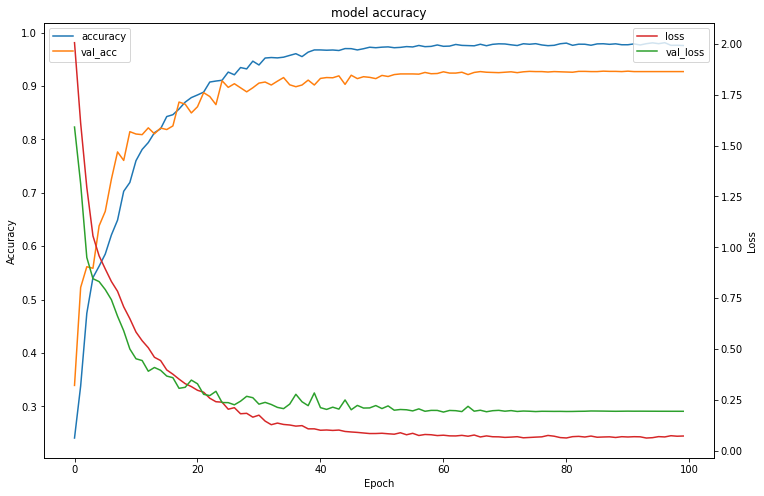

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_acc')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='tab:red', label="loss")
ax2.plot(history.history['val_loss'], color='tab:green', label="val_loss")
ax2.set_ylabel('Loss')

ax2.legend(loc=0)
ax1.legend(loc=0)

plt.title('model accuracy')
plt.show()


# Confusion Matrices

In [34]:
LABELS = ['Biking', 'Downstairs', 'Jogging',
          'Sitting', 'Standing', 'Upstairs', 'Walking']


In [35]:
def confusion_mat(all_model, test_X, test_y, dividor: int = 358):
    y_pred_ohe = all_model.predict(test_X, verbose='silent')
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(test_y, axis=1)
    return metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)/dividor


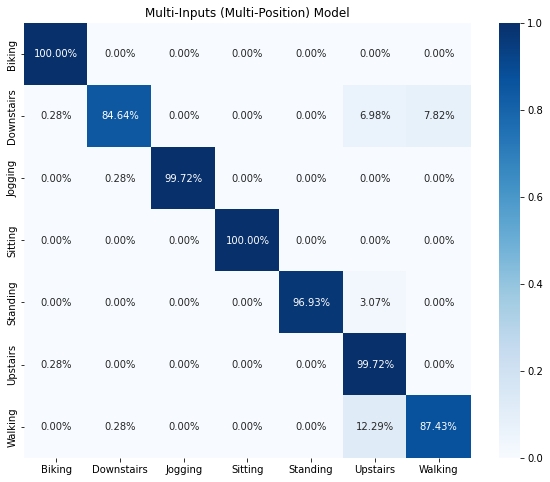

In [36]:
plt.figure(figsize=(10, 8))
plt.title('Multi-Inputs (Multi-Position) Model')
sns.heatmap(confusion_mat(g_model, [model_ua.predict(X_test_upper_arm, verbose='silent'),
                                    model_w.predict(X_test_wrist, verbose='silent'),
                                    model_b.predict(X_test_belt, verbose='silent'),
                                    model_rp.predict(X_test_r_pocket, verbose='silent'),
                                    model_lp.predict(X_test_l_pocket, verbose='silent')],
                          y_test_upper_arm),
            xticklabels=LABELS,  # type: ignore
            yticklabels=LABELS,  # type: ignore
            annot=True, fmt=".2%", cmap='Blues')
plt.show()